In [1]:
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from collections import deque
import numpy as np
import networkx as nx

class Cuadrado():
    def __init__(self, dimensiones = 50, p = 0.45, pared=4, cueva = 5, semilla = None):
        self.semilla = semilla if semilla is not None else random.randint(0, 2**32 - 1)
        random.seed(semilla)
        self.dimensiones = dimensiones
        self.pared = pared
        self.cueva = cueva
        self.mapa = [[True if random.random() < p else False for _ in range(dimensiones)] for _ in range(dimensiones)]
    
    def pintar_mapa(self):
        # Crear un colormap personalizado donde True será blanco y False será negro
        cmap = mcolors.ListedColormap(['blue', 'white'])
        
        plt.figure(figsize=(5, 5))
        plt.imshow(self.mapa, cmap=cmap, interpolation="nearest")
        plt.axis("off")
        plt.show()
    
    def paso_de_simulacion(self):
        temp_mapa = [[None for _ in range(self.dimensiones)] for _ in range(self.dimensiones)]
        for x in range(self.dimensiones):
            for y in range(self.dimensiones):
                vecinos_vivos = self.contar_vecinos_vivos(x, y)
                if self.mapa[x][y]:
                    if vecinos_vivos < self.pared:
                        temp_mapa[x][y] = False
                    else:
                        temp_mapa[x][y] = True
                else:
                    if vecinos_vivos > self.cueva:
                        temp_mapa[x][y] = True
                    else:
                        temp_mapa[x][y] = False
        
        self.mapa = temp_mapa
    def contar_vecinos_vivos(self, x, y):
        '''
            x-1 x x+1
        y-1  #  #  #
         y   #  x  #
        y+1  #  #  #
        '''
        count = 0
        for i in range(-1,2):
            for j in range(-1,2):
                vecino_x = x+i
                vecino_y = y+j
                # No queremos contarnos a nosotros mmismos
                if i == 0 and j == 0:
                    continue
                # Para rellenar los bordes de la cueva, esto puede aplicarse.
                elif vecino_x < 0 or vecino_y < 0 or vecino_x >= self.dimensiones or vecino_y >= self.dimensiones:
                    count += 1
                elif self.mapa[vecino_x][vecino_y]:
                    count += 1
        return count
    
    def mantener_mayor_caverna(self):
        visitados = [[False for _ in range(self.dimensiones)] for _ in range(self.dimensiones)]
        mayor_caverna = []
        
        for i in range(self.dimensiones):
            for j in range(self.dimensiones):
                if not self.mapa[i][j] and not visitados[i][j]:
                    caverna_actual = []
                    cola = deque()
                    cola.append((i, j))
                    visitados[i][j] = True
                    
                    while cola:
                        x, y = cola.popleft()
                        caverna_actual.append((x, y))
                        
                        for dx, dy in [(1,0),(-1,0),(0,1),(0,-1)]:
                            nx = x + dx
                            ny = y + dy
                            if 0 <= nx < self.dimensiones and 0 <= ny < self.dimensiones:
                                if not self.mapa[nx][ny] and not visitados[nx][ny]:
                                    visitados[nx][ny] = True
                                    cola.append((nx, ny))
                    #print(f"Actual {len(caverna_actual)} | Mayor {len(mayor_caverna)}")
                    if len(caverna_actual) > len(mayor_caverna):
                        mayor_caverna = caverna_actual
        nuevo_mapa = [[True for _ in range(self.dimensiones)] for _ in range(self.dimensiones)]
        for x, y in mayor_caverna:
            nuevo_mapa[x][y] = False
        self.mapa = nuevo_mapa
    
    def generar_salas_flood(self, num_semillas=15, visualizar=True):
        """
        Divide la caverna en salas mediante expansión simultánea desde semillas.
        """
        # Obtener celdas accesibles y dimensiones
        celdas_suelo = np.argwhere(np.logical_not(self.mapa))
        dim = self.dimensiones
        
        # Manejar caso sin celdas de suelo
        if len(celdas_suelo) == 0:
            return np.full((dim, dim), -1, dtype=int), []
        
        # Ajustar num_semillas si es necesario
        if len(celdas_suelo) < num_semillas:
            num_semillas = len(celdas_suelo)
        
        # Seleccionar semillas usando random para mantener coherencia con la semilla de la clase
        indices = random.sample(range(len(celdas_suelo)), num_semillas)
        semillas = celdas_suelo[indices]
        
        # Inicializar matriz de salas y cola BFS
        salas = np.full((dim, dim), -1, dtype=int)
        cola = deque()
        
        # Asignar semillas e iniciar expansión
        for idx, (x, y) in enumerate(semillas):
            salas[x, y] = idx
            cola.append((x, y, idx))
        
        # Direcciones de expansión (4-vecinos)
        direcciones = [(-1,0), (1,0), (0,-1), (0,1)]
        
        # Expansión simultánea
        while cola:
            x, y, region = cola.popleft()
            for dx, dy in direcciones:
                nx, ny = x + dx, y + dy
                if 0 <= nx < dim and 0 <= ny < dim:
                    if salas[nx, ny] == -1 and not self.mapa[nx][ny]:
                        salas[nx, ny] = region
                        cola.append((nx, ny, region))
        # Visualización
        if visualizar:
            fig, ax = plt.subplots(figsize=(8, 8))
        
            # Base: blanco para cueva, negro para pared
            base = np.where(self.mapa, 0, 1)
            ax.imshow(base, cmap=ListedColormap(['black', 'white']), origin='upper')
        
            # Dibujar bordes entre salas distintas (pero no con pared)
            bordes = np.zeros((dim, dim))
            for x in range(dim):
                for y in range(dim):
                    if not self.mapa[x][y] and salas[x, y] != -1:
                        for dx, dy in direcciones:
                            nx_, ny_ = x + dx, y + dy
                            if 0 <= nx_ < dim and 0 <= ny_ < dim:
                                if not self.mapa[nx_][ny_] and salas[nx_, ny_] != -1:
                                    if salas[nx_, ny_] != salas[x, y]:
                                        bordes[x, y] = 1
        
            ax.imshow(np.where(bordes == 1, 0.5, np.nan), cmap=ListedColormap(['gray']), alpha=1.0, origin='upper')
        
            # Marcar semillas opcional
            ax.scatter(semillas[:, 1], semillas[:, 0], c='red', s=20, marker='x')
        
            ax.set_title(f'Expansión con bordes entre salas ({num_semillas} semillas)')
            ax.axis('off')
            plt.show()

            
        return salas  
            
            
    def matriz_a_grafo(self, salas):
        """
        Crea un grafo desde la matriz de regiones (salas) generadas por flood fill.
        Cada nodo corresponde al centroide de una sala.
        Las aristas se crean entre regiones adyacentes.
        """
        dim = self.dimensiones
        grafo = nx.Graph()
        regiones = {}

        # Agrupar celdas por región
        for x in range(dim):
            for y in range(dim):
                r = salas[x][y]
                if r != -1:
                    regiones.setdefault(r, []).append((x, y))

        # Añadir nodos en los centroides
        self.centros = {}
        for region, celdas in regiones.items():
            xs, ys = zip(*celdas)
            centroide = (sum(ys) / len(ys), sum(xs) / len(xs))  # (columna, fila)
            grafo.add_node(region, pos=centroide)
            self.centros[region] = centroide

        # Añadir aristas entre regiones adyacentes
        ya_conectados = set()
        for x in range(dim):
            for y in range(dim):
                actual = salas[x][y]
                if actual == -1:
                    continue
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx_, ny_ = x + dx, y + dy
                    if 0 <= nx_ < dim and 0 <= ny_ < dim:
                        vecino = salas[nx_][ny_]
                        if vecino != -1 and vecino != actual:
                            par = tuple(sorted((actual, vecino)))
                            if par not in ya_conectados:
                                ya_conectados.add(par)
                                grafo.add_edge(*par)
        self.grafo = grafo

    def mostrar_mapa_y_grafo(self, salas):
        """
        Muestra el mapa binario (cueva/pared) y bordes solo entre salas diferentes, con grafo superpuesto.
        """
        dim = self.dimensiones
        fig, ax = plt.subplots(figsize=(8, 8))
    
        # Base: blanco para cueva, negro para pared
        base = np.where(self.mapa, 0, 1)
        ax.imshow(base, cmap=ListedColormap(['black', 'white']), origin='upper')
    
        # Bordes solo entre salas distintas
        bordes = np.zeros((dim, dim))
        for x in range(dim):
            for y in range(dim):
                if not self.mapa[x][y] and salas[x, y] != -1:
                    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        nx_, ny_ = x + dx, y + dy
                        if 0 <= nx_ < dim and 0 <= ny_ < dim:
                            if not self.mapa[nx_][ny_] and salas[nx_, ny_] != -1:
                                if salas[nx_, ny_] != salas[x, y]:
                                    bordes[x, y] = 1
    
        ax.imshow(np.where(bordes == 1, 0.5, np.nan), cmap=ListedColormap(['gray']), alpha=1.0, origin='upper')
    
        # Mostrar grafo
        pos = nx.get_node_attributes(self.grafo, 'pos')
        nx.draw(self.grafo, pos, with_labels=True, node_color='red',
                edge_color='yellow', node_size=300, ax=ax, font_size=10)
        nx.draw_networkx_edge_labels(self.grafo, pos,
                                     edge_labels={(u, v): '' for u, v in self.grafo.edges},
                                     font_color='gray', ax=ax)
    
        ax.set_title("Mapa y grafo (solo bordes entre salas)")
        ax.axis('off')
        plt.show()



In [2]:
def automata_celular(iteraciones = 4,dimensiones = 50, p = 0.45, pared = 4, cueva = 5, num_semillas=5,semilla = None):
    mapa = Cuadrado(dimensiones=dimensiones, p=p, pared=pared, cueva=cueva, semilla=semilla)
    for _ in range(iteraciones):
        mapa.paso_de_simulacion()
    mapa.pintar_mapa()
    mapa.mantener_mayor_caverna()
    salas = mapa.generar_salas_flood(num_semillas=10, visualizar=True)
    
    
    mapa.matriz_a_grafo(salas)
    mapa.mostrar_mapa_y_grafo(salas)
    
    return mapa

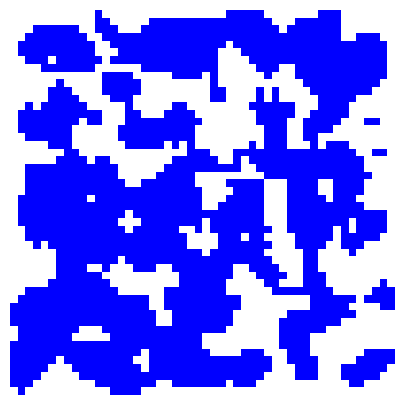

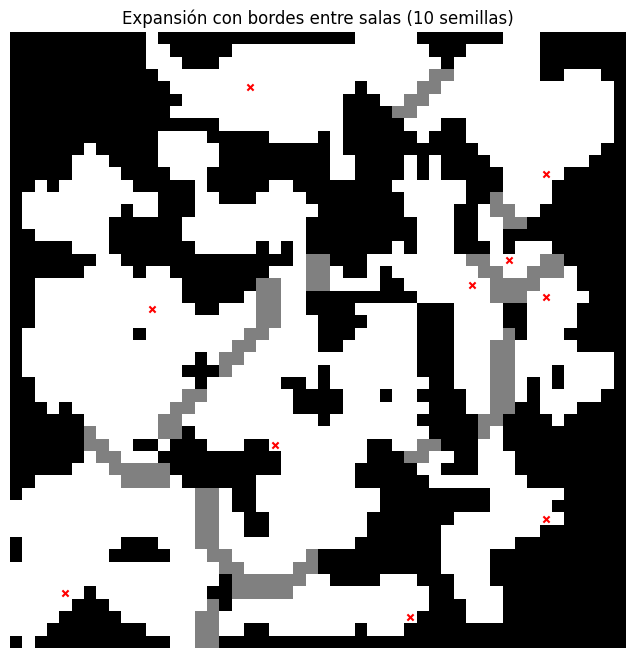

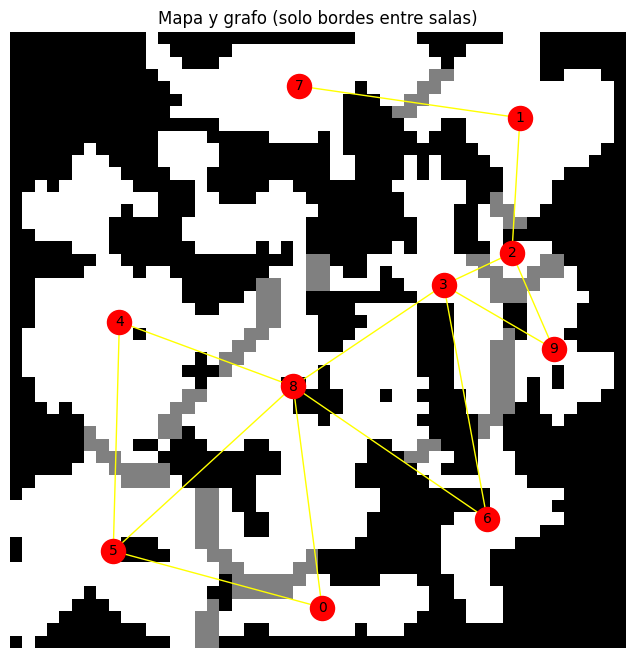

In [10]:
iteraciones = 2
dimensiones = 50
p = 0.6
pared = 5
cueva = 5
semilla = None
mapa = automata_celular(iteraciones=iteraciones, dimensiones=dimensiones, p=p, pared=pared, cueva=cueva, num_semillas = 5, semilla=semilla)

In [4]:
mapa.grafo

In [5]:
def seleccionar_inicio_y_final(grafo):
    inicio = random.choice(list(grafo.nodes))
    distancias = nx.single_source_dijkstra_path_length(grafo, inicio)
    hojas = [n for n in grafo.nodes if grafo.degree[n] == 1]

    if hojas:
        final = max(hojas, key=lambda n: distancias.get(n, -1))
    else:
        final = max(distancias, key=distancias.get)

    return inicio, final


In [6]:
inicio, final = seleccionar_inicio_y_final(mapa.grafo)
print(inicio, final)

4 7


In [7]:
import numpy as np
from scipy.spatial import Voronoi
from matplotlib import pyplot as plt

def generar_salas_voronoi(mapa, num_semillas=15, visualizar=True):
    # Obtener todas las celdas accesibles (suelo)
    celdas_suelo = np.argwhere(np.logical_not(mapa.mapa))
    
    # Generar semillas aleatorias dentro de la caverna usando las celdas de suelo
    if len(celdas_suelo) < num_semillas:
        num_semillas = len(celdas_suelo)
    indices_semillas = np.random.choice(len(celdas_suelo), num_semillas, replace=False)
    semillas = celdas_suelo[indices_semillas]
    
    # Calcular diagrama de Voronoi
    vor = Voronoi(semillas)
    
    # Crear matriz para almacenar las salas (etiquetas numéricas)
    salas = np.full((mapa.dimensiones, mapa.dimensiones), -1, dtype=int)
    
    # Asignar cada celda de suelo a la región de Voronoi más cercana
    for idx, (x, y) in enumerate(celdas_suelo):
        distancias = np.linalg.norm(semillas - [x, y], axis=1)
        region = np.argmin(distancias)
        salas[x, y] = region
    
    # Visualización opcional
    if visualizar:
        plt.figure(figsize=(8, 8))
        plt.imshow(salas, cmap='tab20', interpolation='nearest')  # Usamos una paleta de 20 colores
        plt.scatter(semillas[:, 1], semillas[:, 0], c='black', s=10)  # Dibujar semillas
        plt.axis('off')
        plt.title(f'Segmentación Voronoi ({num_semillas} semillas)')
        plt.show()
    
    return salas, semillas

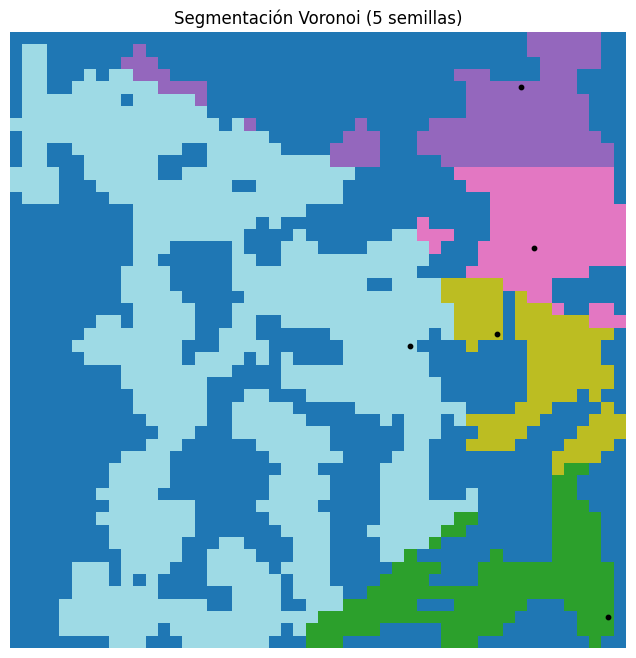

In [8]:
# Generar y visualizar salas Voronoi
salas, semillas = generar_salas_voronoi(mapa, num_semillas=5)